In [1]:
import h5py as h5
import wholebrain as wb
import os
import json
import sys
from opm_img.variables import *
import numba
import rmm
from opm_img.util import save_to_h5
import importlib
from scipy.spatial.transform import Rotation
from scipy.stats import pearsonr
from tqdm.auto import tqdm
import numpy as np
%matplotlib widget
importlib.reload(wb)
import cupy as cp
from matplotlib import pyplot as plt
from types import SimpleNamespace
import tempfile
import subprocess

# SLURM

In [14]:
email="maximilian.hoffmann@charite.de"
out=f'/home/hoffmmax/project/max/feb2023/'
names=['20211105_1332_no_stimulus']#, '20220610_1629_No_stimulus','20220610_1532_No_stimulus','20220610_1428_No_stimulus']

#names=['20211105_1332_no_stimulus']
pars={"global": {"stripe_period":300,
                 "val_fraction":0.2,
                 "test_fraction":0.2,
                 "target_fraction":0.1,
                 },
     "df_est":{"medianfilt_size":7,"minfilt_size":101,"gaussfilt_sigma":101., "truncate":2,"mode":"nearest"},
     "correlation": 
     { "do": True, "ringlims":[25,50]},
     "pca_reg": 
     {"do":True, "dims_list":np.geomspace(1, 1500, 200).tolist(),"n_repeats":20},
     "random_predictors": 
     {"do":True, "n_pred_list": np.r_[100, 500, 2000, 5000, 10000:40000:10000].tolist(),"alpha":100,"n_repeats":20},
     "voxelate":
     {"do":True, "s_bins_dim": np.r_[10:30:10, 30:200:10, 200:501:25].tolist(),"n_pred_list": np.r_[100, 500, 2000, 5000, 10000:40000:10000].tolist(),"alpha":100,"n_repeats":20},
     "r2_scan":
     {"do":True, "s_bins":np.r_[1, 10, 25:100:25, 100:200:50, 200:500:100].tolist(),"n_pred_list": np.r_[100, 500, 2000, 5000, 10000:40000:10000].tolist(),"alphas":np.geomspace(1,400,20).tolist(),"n_repeats":20, "alpha_repeats":5},
     "snr":
     {"do":True, "snr_level": [20, 30, 50, 60, 70, 80] ,"alphas":np.geomspace(1,400,20).tolist(),"n_repeats":20},
     "random_projections":
     {"do":True, "alphas":np.geomspace(0.1, 1e9, 100).tolist(),"n_repeats":20},
      "corr_fc":
     {"do":True, "min_dist":400, "radius_list": [5,10,15,25,50,100,150,200], "save_full_at":[5,50,100,200],"dec_factor":20}
     
    }
     


#Possible steps: "steps":["do_correlation","do_alpha_scan","do_pca_reg","do_voxelate","do_random",'do_constant_R2']

for ii,name in enumerate(names):

        name_job=f"R2_{name}"
        tfile=tempfile.NamedTemporaryFile(dir=JOBS_DIR)
        par_file=tempfile.NamedTemporaryFile(dir=JOBS_DIR,mode="w+",delete=False)
        json.dump(pars,par_file)
        par_file.flush()

        #Submit Job
        s ='#!/bin/bash\n'
        s+='#\n'
        s+='#SBATCH --job-name={}\n'.format(f"{name_job}_GPU")
        s+='#SBATCH --output={}\n'.format(os.path.join(LOGS_DIR,name_job+'_GPU.o'))
        s+='#SBATCH --cpus-per-task=16\n'
        s+='#SBATCH --time=24:00:00\n'
        s+='#SBATCH --mem=128G\n'
        s+='#SBATCH --partition=gpu\n'
        s+='#SBATCH --gres=gpu:1 \n'
        s+=f'#SBATCH --mail-user={email}\n'
        s+='#SBATCH --mail-type=ALL \n'
        s+='eval "$(conda shell.bash hook)"\n'
        s+='conda activate img\n'
        s+='python ./compute_figure_data.py {} {} {} \n'.format(name,par_file.name,out)

        with open(tfile.name,'w') as f:
            f.write(s)   
        bashCommand = "sbatch " +tfile.name
        process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
        output, error = process.communicate()
        #job_id_reg=int(re.findall('\d+', str(output))[0])
        print(output)
        #%squeue -u hoffmmax_c

b'Submitted batch job 804104\n'


# Datasets

In [2]:
 dsets = {"20211105_1332_no_stimulus": {
        "angle": [-4, -4, -9],
        "direction": [1, 1, -1],
        "displacement": [0, 0, 0],
        "thresh": 0.025,
    },
        "20220610_1629_No_stimulus": {

            "angle": [0, -1, -22],
            "direction": [1, 1, 1],
            "displacement": [0, 0, 0],
            "thresh": 0.03,
        },
        "20220610_1532_No_stimulus": {
            "angle": [-4, -2, 13],
            "direction": [1, 1, 1],
            "displacement": [-22, 0, 0],
            "thresh": 0.025,
        },
        "20220610_1428_No_stimulus": {
            "angle": [0, 0, 5],
            "direction": [1, 1, 1],
            "displacement": [30, 0, 0],
            "thresh": 0.02,
        },
        "20221124_1003_No_stimulus": {
            "angle": [0, 1, -4],
            "direction": [1, -1, 1],
            "displacement": [-15, 0, 0],
            "thresh": 0.016,
        },
    }

# Parameters

In [3]:
name="20211105_1332_no_stimulus"
cuda_id=0



pars={"global": {"stripe_period":300,
                 "val_fraction":0.2,
                 "test_fraction":0.2,
                 "target_fraction":0.1,
                 },
     "df_est":{"medianfilt_size":7,"minfilt_size":101,"gaussfilt_sigma":101., "truncate":2,"mode":"nearest"},
     "correlation": 
     { "do": True, "ringlims":[25,50]},
     "pca_reg": 
     {"do":True, "dims_list":np.geomspace(1, 1500, 200).tolist(),"n_repeats":20},
     "random_predictors": 
     {"do":True, "n_pred_list": np.r_[100, 500, 2000, 5000, 10000:40000:10000].tolist(),"alpha":100,"n_repeats":20},
     "voxelate":
     {"do":True, "s_bins_dim": np.r_[10:30:10, 30:200:10, 200:501:25].tolist(),"n_pred_list": np.r_[100, 500, 2000, 5000, 10000:40000:10000].tolist(),"alpha":100,"n_repeats":20},
     "r2_scan":
     {"do":True, "s_bins":np.r_[1, 10, 25:100:25, 100:200:50, 200:500:100].tolist(),"n_pred_list": np.r_[100, 500, 2000, 5000, 10000:40000:10000].tolist(),"alphas":np.geomspace(1,400,20).tolist(),"n_repeats":20, "alpha_repeats":5},
     "snr":
     {"do":True, "snr_level": [20, 30, 50, 60, 70, 80] ,"alphas":np.geomspace(1,400,20).tolist(),"n_repeats":20},
     "random_projections":
     {"do":True, "alphas":np.geomspace(0.1, 1e9, 100).tolist(),"n_repeats":20},
      "corr_fc":
     {"do":True, "min_dist":400, "radius_list": [5,10,15,25,50,100,150,200], "save_full_at":[5,50,100,200],"dec_factor":20}
     
    }
     

    


seed=None
rotation=dsets[name]['angle']
displacement=dsets[name]['displacement']
direc=dsets[name]['direction']
thresh=dsets[name]['thresh']
res = SimpleNamespace()

# Code

In [4]:
root="/home/hoffmmax/group_shares/project/max/feb2023"

In [8]:
dset=dsets[name]
p_out=os.path.join(root, name)
os.makedirs(p_out, exist_ok=True)
rotation = dset["angle"]
displacement = dset["displacement"]
thresh = dset["thresh"]
direction = dset["direction"]

# pars = SimpleNamespace(**pars)
res = SimpleNamespace()

cuda_id = 0
dev1 = cp.cuda.Device(cuda_id)
dev1.use()
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)
numba.cuda.set_memory_manager(rmm.RMMNumbaManager)

p_target = os.path.join(RES_DIR, name)
fn = os.path.join(p_target, "traces.h5")

In [9]:
fh5_l = h5.File(os.path.join(p_out, f"res_large.h5"), "w")

with h5.File(fn, "r") as h5file:
    traces = h5file["traces"][:]
    cts = h5file["cts"][:]
    pxsz = h5file["pxsz"][:]
    metric = h5file["metric"][:]
    print(h5file.keys())

if thresh is None:
    thresh = 0

with h5.File(fn, 'r') as h5file:
    corr_f = h5file['corr_f'][:]
    mask = h5file['mask'][:]
indx = (corr_f * mask)[tuple([x for x in cts.T])] > thresh
cts = cts[indx]
traces = traces[indx]

coords_raw = cts * pxsz[None, :]
trace_mask = wb.legacy.find_movement(metric)
coords = Rotation.from_euler("xyz", rotation, degrees=True).apply(coords_raw)
res.coords = coords - coords.mean(0)
coords[:] += displacement
coords = coords * direction

<KeysViewHDF5 ['corr', 'corr_f', 'cts', 'dt', 'mask', 'mean', 'metric', 'pxsz', 'traces']>


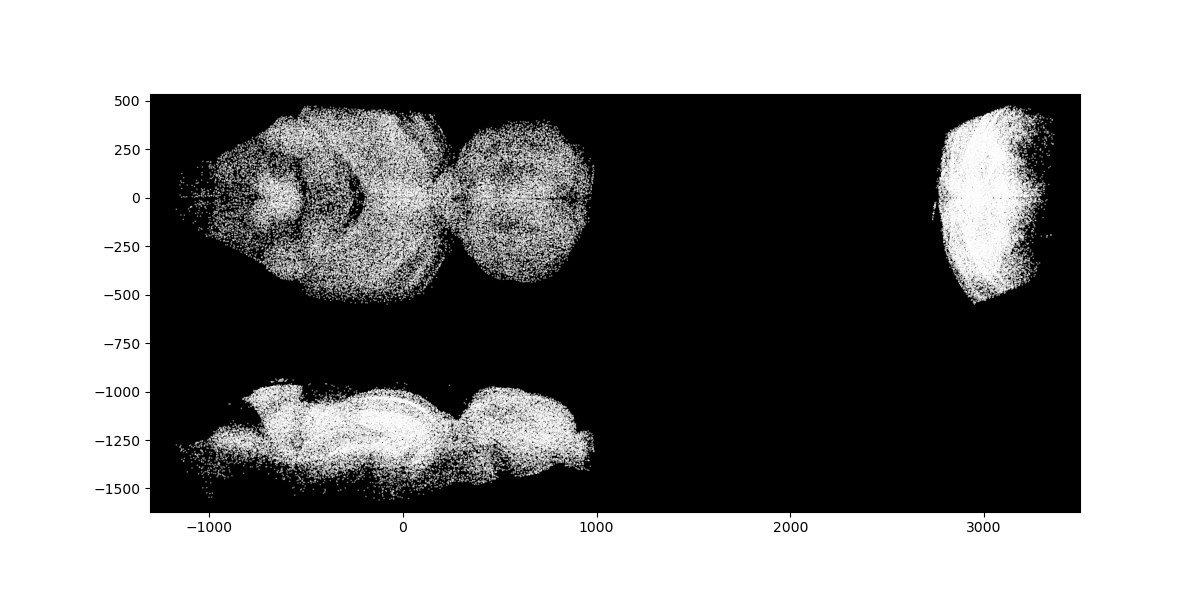

(<Figure size 1200x600 with 2 Axes>, <AxesSubplot: >)

In [10]:
wb.visualize.scatter_brain(res.coords, s=1,alpha=0.5,plot_midline=True)

In [11]:
dff_traces, bsl = wb.traces.getdff_seg(traces, trace_mask, **pars["df_est"])
dff_traces = dff_traces[(~np.isnan(dff_traces[:, 0])), :]
dff_traces_m = dff_traces - dff_traces.mean(0)
res.dff_traces_m = dff_traces_m
#res.clix = wb.embed1D(dff_traces_m)

n_targets = int(dff_traces.shape[1] * pars["global"]["target_fraction"])
cv_ind = (
    np.arange(dff_traces_m.shape[0]) % pars["global"]["stripe_period"]
) / pars["global"]["stripe_period"]
cv_test = (
    cv_ind > 1 - (pars["global"]["test_fraction"] + pars["global"]["val_fraction"])
) * (cv_ind <= (1 - pars["global"]["val_fraction"]))
cv_val = cv_ind > (1 - pars["global"]["val_fraction"])
cv_train = ~(cv_test + cv_val)
assert np.sum(cv_test * cv_val) == 0
test = np.random.randn(dff_traces_m.shape[0])
assert (
    np.sum(test[cv_test + cv_train][cv_train[cv_test + cv_train]] - test[cv_train])
    == 0
)

The padding necessary for mirrored continuation is bigger than the minimum segment length. This can lead to underestimation of baseline.


<module 'wholebrain.stats' from '/home/hoffmmax/repos/wholebrain/wholebrain/stats.py'>

In [11]:
if pars["correlation"]["do"]:

    cc = wb.stats.corrx(cp.array(dff_traces_m), cp.array(dff_traces_m)).get()
    pd = wb.cluster.pdist(res.coords, res.coords)
    fh5_l["ipsi_cc"], fh5_l["contra_cc"] = wb.legacy.neighbourhood_correlation(
        res.coords, cc, **pars["correlation"]
    )
    fh5_l["cc"] = cc
    fh5_l["pd"] = pd
    

/home/hoffmmax/repos/wholebrain/wholebrain/legacy.py:61: RuntimeWarning: invalid value encountered in divide
  ipsi_cc = np.sum((cc * mask_ipsi), axis=axis) / np.sum(mask_ipsi, axis=axis)
/home/hoffmmax/repos/wholebrain/wholebrain/legacy.py:62: RuntimeWarning: invalid value encountered in divide
  contra_cc = np.sum((cc * mask_contra), axis=axis) / np.sum(mask_contra, axis=axis)


In [18]:
if pars["corr_fc"]["do"]:
    fh5_l["fc_before"], fh5_l["fc_corr_mean"], fh5_l["fc_after"] = wb.legacy.corr_fc(
        cc, pd, dff_traces_m, **pars["corr_fc"]
    )

KeyboardInterrupt: 

In [19]:
if pars["pca_reg"]["do"]:
    r2_bcvpca = wb.legacy.pca_run(
        dff_traces_m,
        cv_test + cv_train,
        pars["pca_reg"]["dims_list"],
        n_targets=n_targets,
        n_repeats=pars["pca_reg"]["n_repeats"],
    )


  0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
if pars["voxelate"]["do"]:
    nnz, r2_voxelate = wb.legacy.voxelate_regression(
        pars["voxelate"]["s_bins_dim"],
        dff_traces_m,
        coords,
        cv_test + cv_train,
        n_targets=n_targets,
        n_repeats=pars["voxelate"]["n_repeats"],
        alpha=pars["voxelate"]["alpha"],
    )
    nnz.to_netcdf(os.path.join(root, name, "nnz.netcdf"))
    r2_voxelate.to_netcdf(os.path.join(root, name, "r2_voxelate.netcdf"))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

NameError: name 'out' is not defined

In [35]:
importlib.reload(wb.legacy)
importlib.reload(wb.visualize)
importlib.reload(wb.cluster)
importlib.reload(wb.stats)
importlib.reload(wb.regression)

<module 'wholebrain.regression' from '/home/hoffmmax/repos/wholebrain/wholebrain/regression.py'>

In [33]:
if pars["random_predictors"]["do"]:
    res.r2_rand_pred = wb.legacy.ridge_random(
        dff_traces_m,
        pars["random_predictors"]["n_pred_list"],
        cv_test + cv_train,
        n_repeats=pars["random_predictors"]["n_repeats"],
        alpha=pars["random_predictors"]["alpha"],
        n_targets=n_targets,
    )
    

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [36]:
if pars["r2_scan"]["do"]:
    R2s = wb.legacy.voxelate_alpha_scan(
        pars["r2_scan"]["s_bins"],
        pars["r2_scan"]["n_pred_list"],
        coords,
        dff_traces_m,
        cv_test,
        cv_train,
        pars["r2_scan"]["alphas"],
        n_repeats=pars["r2_scan"]["alpha_repeats"],
        n_targets=n_targets,
    )
    alphas_max = R2s.mean("repeats").idxmax("alphas")

    R2s_val, batch_id = wb.legacy.voxelate_all(
        pars["r2_scan"]["s_bins"],
        pars["r2_scan"]["n_pred_list"],
        coords,
        dff_traces_m,
        cv_train + cv_test,
        alphas_max,
        n_repeats=pars["r2_scan"]["n_repeats"],
        n_targets=n_targets,
    )
    R2s.to_netcdf(os.path.join(root, name, "R2s.netcdf"))
    batch_id.to_netcdf(os.path.join(root, name, "batch_id.netcdf"))
    R2s_val.to_netcdf(os.path.join(root, name, "R2s_val.netcdf"))

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [ ]:
if pars["snr"]["do"]:
    noise = np.median(np.abs(np.diff(dff_traces_m, axis=0)), axis=0, keepdims=True)
    SNR = dff_traces_m.std(0, keepdims=True) / noise

    snr_list = [np.percentile(SNR, x) for x in pars["snr"]["snr_level"]]

    for isn, snr in tqdm(enumerate(snr_list), leave=False):
        mask = SNR.squeeze() > snr
        masked_dff = dff_traces_m[:, mask]
        n_targets_snr = masked_dff.shape[1] // 10

        R2s = wb.legacy.voxelate_alpha_scan(
            pars["r2_scan"]["s_bins"],
            pars["r2_scan"]["n_pred_list"],
            coords[mask],
            masked_dff,
            cv_test,
            cv_train,
            pars["snr"]["alphas"],
            n_repeats=pars["snr"]["n_repeats"],
            n_targets=n_targets_snr,
        )
        alphas_max = R2s.mean("repeats").idxmax("alphas")
        R2s_val, batch_id = wb.legacy.voxelate_all(
            pars["r2_scan"]["s_bins"],
            pars["r2_scan"]["n_pred_list"],
            coords[mask],
            masked_dff,
            cv_train + cv_test,
            alphas_max,
            n_repeats=pars["snr"]["n_repeats"],
            n_targets=n_targets_snr,
        )
        R2s.to_netcdf(os.path.join(root, name, f"R2s_snr_{isn}.netcdf"))
        R2s_val.to_netcdf(os.path.join(root, name, f"R2s_val_snr_{isn}.netcdf"))
        batch_id.to_netcdf(os.path.join(root, name, f"batch_id_snr_{isn}.netcdf"))

0it [00:00, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [37]:
if pars["random_projections"]["do"]:

    R2s_rnd = wb.legacy.rand_projections(
        dff_traces_m,
        pars["r2_scan"]["n_pred_list"],
        cv_train,
        cv_test,
        n_targets=n_targets,
        **pars["random_projections"],
    )
    R2s_rnd.to_netcdf(os.path.join(root, name, "R2s_rnd.netcdf"))

save_to_h5(os.path.join(root, name, f"res.h5"), res.__dict__)

with open(os.path.join(root, name, f"pars.h5"), "w") as f:
    json.dump(pars, f)



AttributeError: module 'wholebrain.legacy' has no attribute 'rand_projections'

  0%|          | 0/8 [00:00<?, ?it/s]

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 816746736 is different from 40417)

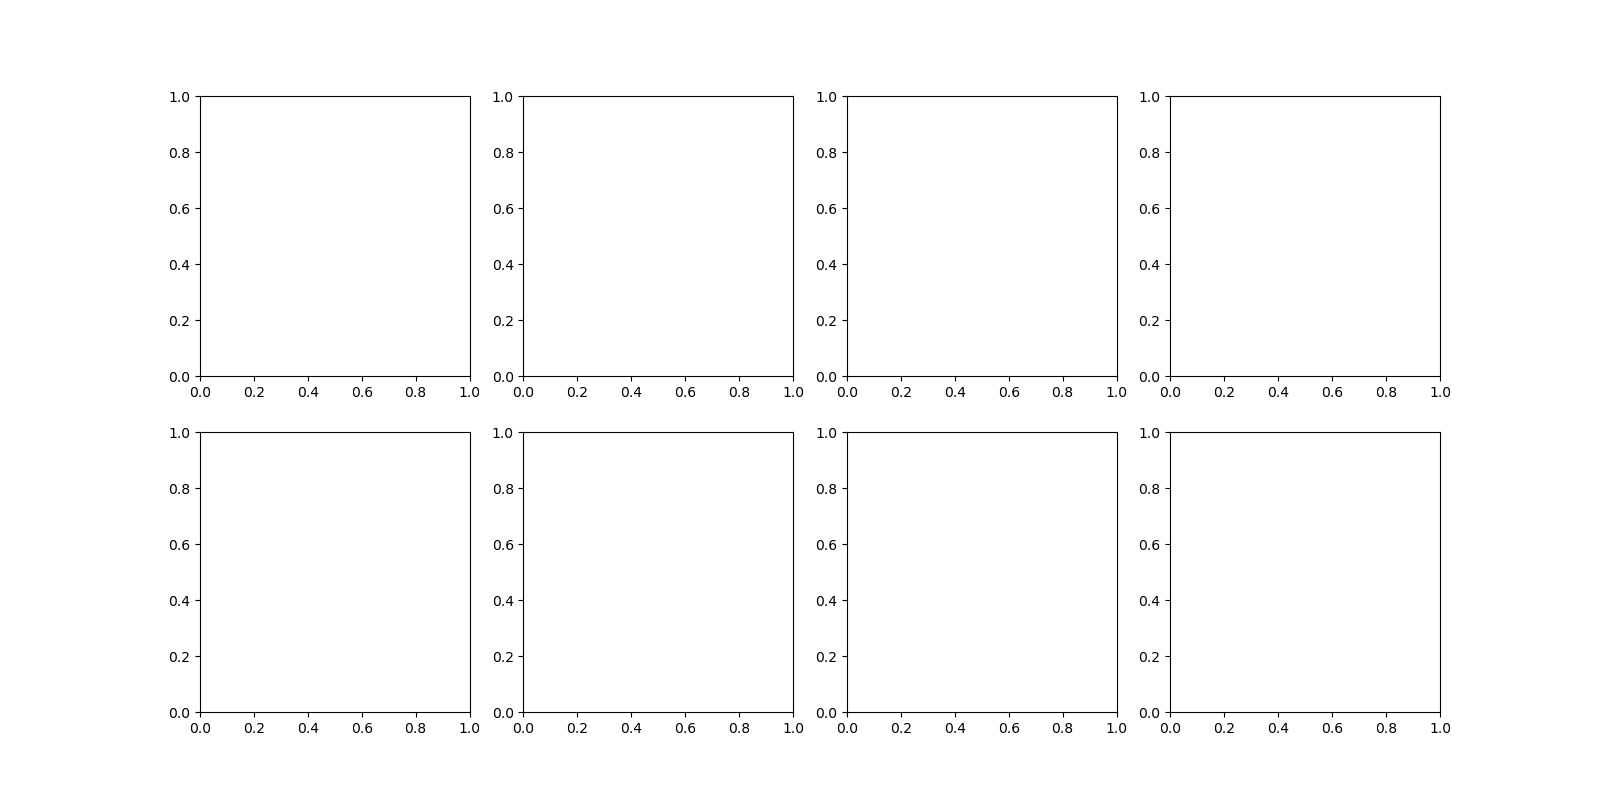

In [12]:
from scipy.stats import pearsonr
from tqdm.auto import tqdm
y_list=[]
cc = wb.stats.corrx(cp.array(dff_traces_m),cp.array(dff_traces_m)).get()
pd = wb.cluster.pdist(coords,coords)

fig, ax = plt.subplots(2,4, figsize=(16,8))

mask = (pd>400)
mask[mask==0] = np.nan
radius_list = [5,10,15,25,50,100,150,200]
fig_rad=[5,50,100,200]
r_all = []

for i, s in enumerate(tqdm(radius_list)):
    kernel = (pd<=s).astype('float32')
    kernel = kernel/kernel.sum(0, keepdims=True)
    dff_traces_m_la = dff_traces_m @ kernel
    del kernel
    cc_corr_dff_la = wb.stats.corrx(cp.array(dff_traces_m_la), cp.array(dff_traces_m_la)).get()
    x = (cc*mask).flatten()[::17]
    cc_corr_dff_la *= mask
    y = cc_corr_dff_la.flatten()[::17]
    if s in [10, 20, 50, 100]:
        y_list.append(y)
    r = pearsonr(x[~np.isnan(x)],y[~np.isnan(x)])
    r_all.append(r)
    ax.flatten()[i].hist2d(x, y, bins=np.linspace(-.75,.75,200), cmap='Greys');
    ax.flatten()[i].set_aspect('equal', 'box')
    ax.flatten()[i].set_title(f'voxel radius {s} µm, r: {r[0]:.2f}')

r_all = np.array(r_all)
    
fig.supxlabel('correlation before smoothing')
fig.supylabel('correlation after smoothing')

plt.figure()
plt.plot(radius_list, r_all)
plt.gca().set(xlim=(0,None), ylim=(0,1.1), xlabel='voxel radius', ylabel='Pearson r')

fig,ax=plt.subplots(figsize=(40/i2m,40/i2m))
ax.plot(radius_list, r_all[:,0],color='k')
ax.set(xlim=(0,None), ylim=(0,1.1), xlabel='voxel radius (µm)', ylabel='Pearson r')
plt.savefig(os.path.join(p_target,'corr_FC.pdf'),dpi=600)

fig,axi=plt.subplots(1,3,figsize=(95/i2m,50/i2m))
for ii,s in enumerate([10,50,100]):
    indx=radius_list.index(s)
    
    axi[ii].hist2d(x, y_all[ii],  bins=np.linspace(-.75,.75,200), cmap='Greys',rasterized=True);
    axi[ii].set_aspect('equal', 'box')
    axi[ii].set_title(f'voxel radius {s} µm, r: {r_all[indx,0]:.2f}')
plt.savefig(os.path.join(p_target,'corr_FC_panel.pdf'),dpi=600)